In [2]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from transformers import AutoTokenizer
import torch
import io
import os
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.metrics import classification_report,accuracy_score
import transformers
import json
from tqdm.notebook import tqdm
from transformers.utils.dummy_pt_objects import AutoModelForSequenceClassification
from transformers import AutoModelForTokenClassification,AutoConfig,AutoModel,AutoTokenizer,BertModel,BertConfig,AdamW, get_constant_schedule,BertForSequenceClassification,get_linear_schedule_with_warmup
import random
import numpy as np
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Mini_Project/new_emdedding trial/total_aug_data_embeddings.csv")
df.head

<bound method NDFrame.head of              0         1         2         3         4         5         6  \
0    -0.189383 -0.512112  0.159589  0.105721 -0.022089 -0.013843  0.631365   
1    -0.120896 -0.301433  0.449453  0.895022 -0.364404  0.198837  0.972379   
2    -0.422645  0.177867  0.345519 -0.468783 -0.181071  0.298927  0.991848   
3     0.224844  0.313443  0.473170  0.647836 -0.639169 -0.243967  0.975003   
4     0.222466 -0.512989 -0.802654 -0.315526 -0.266682 -0.086499  0.961327   
...        ...       ...       ...       ...       ...       ...       ...   
5995  0.383580  0.383296  0.789306  0.918572  0.044842  0.096953  0.977798   
5996 -0.351006 -0.199996  0.241189  0.824066  0.600923  0.515042  0.997284   
5997 -0.288159  0.320180  0.447537  0.962554  0.139887  0.295315  0.997674   
5998 -0.052403 -0.685488  0.068435  0.212213 -0.021940 -0.079330 -0.392391   
5999  0.236943  0.206964  0.424249  0.830852 -0.310356  0.388003  0.996875   

             7         8         

In [6]:
df_0 = df[df['target']==0]
df_1 = df[df['target']==1]
print(df_0.shape)
print(df_1.shape)

(3000, 770)
(3000, 770)


In [7]:
df_train_0 = df_0.iloc[:2400,:]
df_train_1 = df_1.iloc[:2400,:]
train = df_train_0.append(df_train_1)
df_test_0 = df_0.iloc[2400:3000,:]
df_test_1 = df_1.iloc[2400:3000,:]
test = df_test_0.append(df_test_1)

train = train.sample(frac=1)
test = test.sample(frac=1)

<ipython-input-7-352823887ca8>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = df_train_0.append(df_train_1)
<ipython-input-7-352823887ca8>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = df_test_0.append(df_test_1)


In [11]:
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = TFBertForSequenceClassification.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN):
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  test_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  return train_InputExamples, test_InputExamples

  train_InputExamples, test_InputExamples = convert_data_to_examples(train,
                                                                           test,
                                                                           'DATA_COLUMN',
                                                                           'LABEL_COLUMN')
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [12]:
DATA_COLUMN = 'title'
LABEL_COLUMN = 'target'

train_InputExamples, test_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

model_fit=model.fit(train_data, epochs=2)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/2
300/300 [==============================] - 300s 784ms/step - loss: 0.1631
Epoch 2/2
300/300 [==============================] - 228s 760ms/step - loss: 0.0193


In [ ]:
tp = 0
fp = 0
tn = 0
fn = 0
for title, label in zip(test['title'], test['target']):
  tf_batch = tokenizer(title, max_length=128, padding=True, truncation=True, return_tensors='tf')
  tf_outputs = model(tf_batch)
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
  pred_label = tf.argmax(tf_predictions, axis=1)
  if pred_label == 1 and label == 1:
    tp +=1
  elif pred_label == 1 and label == 0:
    fp +=1
  elif pred_label == 0 and label == 0:
    tn +=1
  else:
    fn +=1

accuracy = (tp+tn)/(tp+fp+fn+tn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1score = 2*((recall*precision)/(recall+precision))
print([tp,fn])
print([fp,tn])
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))
print('F1-score: {:.2f}%'.format(f1score*100))

[595, 5]
[8, 592]
Accuracy: 98.92%
Precision: 98.67%
Recall: 99.17%
F1-score: 98.92%


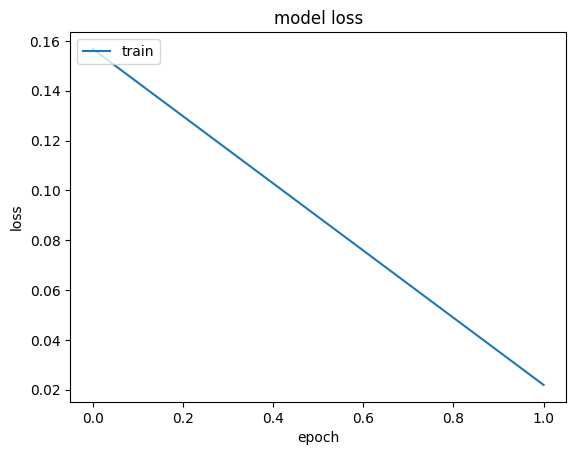

In [ ]:
# summarize history for loss
plt.plot(model_fit.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('bert_loss.jpeg')

In [ ]:
def check_sarcasm(sentence):
    tf_batch = tokenizer(sentence, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    pred_label = tf.argmax(tf_predictions, axis=1)

    if pred_label == 1:
        return "Sarcastic"
    else:
        return "Not sarcastic"

# Example usage
sentence = "Μεξικό: 25 νεκροί από την πτώση λεωφορείου στον γκρεμό"
result = check_sarcasm(sentence)
print(result)

Not sarcastic


In [ ]:
model.save_pretrained("/content/drive/MyDrive/Mini_Project/new_emdedding trial")

In [13]:
# Initialize an empty list to store the predictions
predictions = []

# Iterate over the test data
for title, label in zip(test['title'], test['target']):
  tf_batch = tokenizer(title, max_length=128, padding=True, truncation=True, return_tensors='tf')
  tf_outputs = model(tf_batch)
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
  pred_label = tf.argmax(tf_predictions, axis=1)

  # Append the prediction to the list
  predictions.append(pred_label.numpy()[0])

# Add the predictions as a new column in the DataFrame
test['predictions'] = predictions

# Print the updated DataFrame
test

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,title,target,predictions
5714,0.611613,0.106558,0.626702,0.584032,-0.093598,0.487521,0.999510,0.528639,0.152895,-0.071045,...,-0.843744,-0.154025,0.010171,-0.432887,-0.101652,-0.852903,-0.750099,ενέκρινε το ευρωκοινοβούλιο την παροχή δανείου...,1,1
5479,0.365987,-0.014720,0.248017,0.973251,0.298771,0.480343,0.990353,0.842047,0.584619,0.231216,...,-0.880748,-0.024890,-0.402449,0.022955,-0.101515,-0.932067,-0.827726,σε αρχαίο χίπστερ ανήκε ο μηχανισμός των αντικ...,1,1
5420,0.085372,0.122369,0.796312,-0.292087,-0.147962,0.015812,0.996904,0.327904,-0.066598,-0.269073,...,-0.736461,0.244302,-0.223721,-0.329072,-0.503541,-0.828467,-0.654116,ρεπορτάζ: πολύ κοντά στην ανάπτυξη ονειροπαγίδ...,1,1
2695,0.466582,0.498272,0.282541,0.661564,-0.403065,-0.688999,0.998684,0.269693,-0.475809,-0.227233,...,-0.531335,0.179532,0.244964,-0.379006,0.079408,-0.395853,-0.410389,το καραμανλικό σοκ των ανωγείων κλονίζει τον μ...,0,0
5512,-0.006628,0.162512,0.411170,0.627860,-0.311332,0.440479,0.997227,0.729647,0.795274,-0.126247,...,-0.741369,-0.218093,0.216995,-0.441190,-0.207310,-0.951425,-0.863750,βιβλική παντόφλα και χθες για τον άγιο σπυρίδωνα,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5622,-0.253040,0.166469,0.437503,0.953531,0.332313,0.429197,0.996777,0.709909,0.925846,-0.537940,...,-0.669242,0.136562,0.208056,0.127819,-0.222385,-0.892715,-0.614281,μήνυση λόγω χαζομάρας θα μπορεί να υποβάλει όπ...,1,1
2940,-0.285440,0.039712,0.628262,0.852978,-0.126823,0.280530,0.980792,0.823482,0.990227,-0.516937,...,-0.980600,-0.072760,-0.002136,-0.637928,-0.249106,-0.991909,-0.684704,eurostat: πρώτοι στην απώλεια εισοδήματος οι φ...,0,0
5754,0.349549,-0.280170,0.005063,0.573398,-0.135212,-0.005608,0.989370,0.545648,0.857920,0.059961,...,-0.889156,0.348939,0.160523,-0.351918,0.088293,-0.994624,-0.339517,όταν χιονίζει δεν είναι ωραίο να μένουν άνθρωπ...,1,1
2554,-0.042728,-0.258262,0.123221,0.949441,0.181914,0.250408,0.969563,0.761815,0.776166,-0.400558,...,-0.953039,0.061077,0.317870,-0.474137,0.210982,-0.928982,-0.554597,πληροφορίες για σύλληψη του μένιου φουρθιώτη,0,0


In [14]:
columns_to_keep = ['title', 'target', 'predictions']

# Select the desired columns using indexing
test = test[columns_to_keep]
test

,title,target,predictions
5714,ενέκρινε το ευρωκοινοβούλιο την παροχή δανείου...,1,1
5479,σε αρχαίο χίπστερ ανήκε ο μηχανισμός των αντικ...,1,1
5420,ρεπορτάζ: πολύ κοντά στην ανάπτυξη ονειροπαγίδ...,1,1
2695,το καραμανλικό σοκ των ανωγείων κλονίζει τον μ...,0,0
5512,βιβλική παντόφλα και χθες για τον άγιο σπυρίδωνα,1,1
...,...,...,...
5622,μήνυση λόγω χαζομάρας θα μπορεί να υποβάλει όπ...,1,1
2940,eurostat: πρώτοι στην απώλεια εισοδήματος οι φ...,0,0
5754,όταν χιονίζει δεν είναι ωραίο να μένουν άνθρωπ...,1,1
2554,πληροφορίες για σύλληψη του μένιου φουρθιώτη,0,0


In [15]:
test.to_csv('/content/drive/MyDrive/Mini_Project/new_emdedding trial/preds_on_test.csv', index=False)

In [25]:
df=pd.read_csv('/content/drive/MyDrive/Mini_Project/new_emdedding trial/preds_on_test.csv')

new_df = df[['title']].copy()

# Save the new DataFrame to a CSV file
new_df.to_csv('/content/drive/MyDrive/Mini_Project/new_emdedding trial/test_headlines.csv', index=False)
